# Project Kojak - Weeks 09 - 12

## Main speaker recognition / classification routines.
(Jupyter Notebook 4 of 4)

### This notebook

This notebook set trains the 100 household groups and tests it with new audio from the same speakers and from unfamiliar (out-of-group) speakers. The data sets were created in the 2nd notebook, AudioGrouping.ipynb.

The notebook calls extensively from the custom utility function, SpeechAnalysis.py.

In [1]:
import numpy as np
import glob`
import  os
from itertools import compress

import soundfile as sf
import librosa, librosa.display

from scipy import signal
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt

In [7]:
import Speech_Analysis  # custom module, facilitating notebook reloads
import importlib
importlib.reload(Speech_Analysis)
from Speech_Analysis import get_wavfiles, log_spectrogram, play_nstaudio
from Speech_Analysis import nmf_decomp, create_groupdict

In [5]:
# Get audio data for training (device groups) and test sets #
# These were previously saved in AudioGrouping.py.
import pickle

with open('data/batch_training02.pkl', 'rb') as picklefile:
    batch_training = pickle.load(picklefile)
    
with open('data/batch_test02.pkl', 'rb') as picklefile:
    batch_test = pickle.load(picklefile)

In [284]:
# Function to calculate the NMF solution with a group sparsity constraint #
# The algorithm is based on the work of Badawy et al, 2015  (which itself cites
# Lefevre et al, 2011).
def nmf_gsparse(Hinit, W, Atrue, wid, lam=1, niter=20, eps=1e-30):
    H = Hinit
    
    for n in range(niter):
        A = W.dot(H)
        Pj = []
        
        for j in np.unique(wid):
            Hj = Hinit[wid==j,:]
            normj = np.linalg.norm(Hj, 1, axis=0, keepdims=True)
            normj = normj.repeat(Hj.shape[0], axis=0)
            Pj.append(lam / (eps + normj))
        
        P = np.vstack(Pj)
        
        num = W.T.dot(Atrue * A**(-2))
        den = W.T.dot(A**(-1)) + P
        H = H * (num/den)**.5
    
    return H

In [445]:
# Set the hyperparameters - easiest just to manually change #
NCOMPONENT = 10                # K for NMF
FREQRANGE = (50, 6000)         # limit frequencies of interest; in Hz
TRIM = 10                      # higher scaling value = more aggresive removal of quiet times
CONFIDENCE = 1.05              # factor by which max-energy spkr must be greater than next-highest
ALPHA, L1_RATIO = 0.05, 0.7    # only for dictionary creation

NTEST_OUT = 9                  # number of out-of-group audio files to test (in group has 18)
DICT_OUT = False
SPARSE = True

In [366]:
# Failed attempt to augment the in-group dictionary with random out-of-group features #
# This was ultimately always set to False in the final model runs.
if DICT_OUT:
    wavidx = np.random.permutation(len(batch_test))[:NTEST_DICT]
    wavbunch = [batch_test[i] for i in wavidx]
    group_temp = {'speakers':['TEST'],'train':[wavbunch]}

    dd_nonmember, _ = create_groupdict(group_temp, ncomp=NCOMPONENT, frange=FREQRANGE,
                          trim=TRIM, alpha=ALPHA, l1_ratio=L1_RATIO)
else:
    dd_nonmember = []

In [446]:
# The model run, which both trains and tests the 100 groups #
NTRY = 100    # set to 100 to run on all the data

batch_result = {}
print('Processing...')

for gnum in range(1,NTRY+1):
    group_info = batch_training[gnum]
    batch_result[gnum] = {'ytrue':[], 'ypred':[], 'pct_energy1':[], 'pct_energy2':[]}
    
    # Create group dictionary matched to speakers #
    # ddid = speaker id for dictionary; spid = speaker id for test audio files.
    dd, ddid = create_groupdict(group_info, ncomp=NCOMPONENT, frange=FREQRANGE,
                                trim=TRIM, alpha=ALPHA, l1_ratio=L1_RATIO)
    
    # Loop through all of the group's test wav files, keeping track of speaker ids #
    wavbunch = [wavfile for spwav in group_info['test'] for wavfile in spwav]
    wavid = [sp for j in range(len(group_info['test'])) \
                for sp in j*np.ones((1,len(group_info['test'][j])),dtype=int)]
    wavid = [k for ka in wavid for k in ka]  # each wavid[] corresponds to wavbunch[]

    # Add to test set a random sampling of out-of-group wav files #
    testidx = np.random.permutation(len(batch_test))[:NTEST_OUT]
    wavbunch = wavbunch + [batch_test[i] for i in testidx]
    wavid = wavid + [-1]*NTEST_OUT
    
    # Also augment in-group dictionary with out-of-group dictionary #
    if DICT_OUT:
        dd = np.append(dd,dd_nonmember,axis=1)
        ddid = np.append(ddid,-1*np.ones(dd_nonmember.shape[1]))
    spid = np.unique(ddid)
    nsp = len(spid)
    
    # Loop through all the test audio files and compile results #
    for i in range(len(wavbunch)):
        wavfile = wavbunch[i]
        wavtest, srate = sf.read(wavfile)
        
        # Calculate the spectrogram for current wav file #
        freqs, times, SSwav = log_spectrogram(wavtest, srate, freq_lim=FREQRANGE)
        SSwav = SSwav + abs(SSwav.min())  # size F x T
        if TRIM:  # optionally remove quiet portions (little low-freq energy)
            SSavg = SSwav[2:102,:].mean(axis=0)
            cutoff = (SSavg[4:].max()/SSwav[:2].max()) * TRIM
            SSwav_trimmed = SSwav[:,SSavg > cutoff*SSavg[:2].mean()]
            if SSwav_trimmed.shape[1] >= 0.3*SSwav.shape[1]:
                SSwav = SSwav_trimmed

        # Calculate the NMF activations for the spectrogram #
        nmf_model3 = NMF(NCOMPONENT, solver='mu', beta_loss='kullback-leibler',
                         alpha=0.0, l1_ratio=0.0, max_iter=400);
        nmf_model3.fit(SSwav.T);
        nmf_model3.components_ = dd.T
        nmf_model3.n_components_ = dd.T.shape[0]

        Vtest = nmf_model3.transform(SSwav.T).T

        # Refine the activations by imposing sparsity (all-or-nothing speaker dict. entries)
        if SPARSE:
#             Vinit = np.random.rand(*(Vtest.shape)) * np.linalg.norm(Vtest,1)
            Vinit = Vtest
            Vtest = nmf_gsparse(Vinit, dd, SSwav, ddid, lam=1, niter=30)
        
        # Sum across time to get total activation #
        Venergy = Vtest.sum(axis=1)

        # Determine the best speaker id (0,1,..,NSPKR-1,and -1 for non-group) #
        sp_score = np.zeros(nsp)
        for j,sp in enumerate(spid):
            sp_score[j] = Venergy[ddid==sp].sum()
        idx_best = sp_score.argmax()
        sp_best = spid[idx_best]
        
        pct1 = sp_score.max()/sp_score.sum()
        batch_result[gnum]['pct_energy1'].append(pct1)
        
        temp = np.append(sp_score[:idx_best],sp_score[idx_best+1:])
        pct2 = temp.max()/sp_score.sum()
        batch_result[gnum]['pct_energy2'].append(pct2)
        
        # Set to -1 if pct1/pct2 ratio isn't high enough #
        if pct1/pct2 < CONFIDENCE:
            sp_best = -1
        batch_result[gnum]['ypred'].append(sp_best)
        
    batch_result[gnum]['ytrue'] = wavid
    # end i over wav files #
    
    print(gnum, end=' ')
    if not gnum%10:
        print()
    # end gnum over groups #
    
print('Done')

Processing...
1 2 3 4 5 6 7 8 9 10 
11 12 13 14 15 16 17 18 19 20 
21 22 23 24 25 26 27 28 29 30 
31 32 33 34 35 36 37 38 39 40 
41 42 43 44 

/Users/neuromac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in power
  app.launch_new_instance()
/Users/neuromac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/Users/neuromac/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


45 46 47 48 49 50 
51 52 53 54 55 56 57 58 59 60 
61 62 63 64 65 66 67 68 69 70 
71 72 73 74 75 76 77 78 79 80 
81 82 83 84 85 86 87 88 89 90 
91 92 93 94 95 96 97 98 99 100 
Done


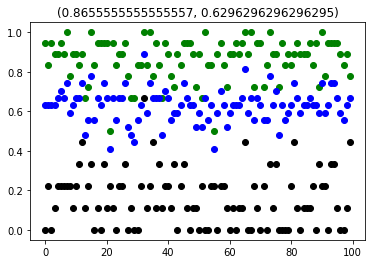

In [448]:
# Get a quick look at accuracy vs diversity ranking for both in- and out-of-group audio #
# It turns out that diversity didn't correlate with any accuracy score.
accuracy_in, accuracy_out = [], []
accuracy_total = []
diversity = []

for i in range(1,len(batch_result)+1):
    ytrue = np.array(batch_result[i]['ytrue'])
    ypred = np.array(batch_result[i]['ypred'])
    accuracy_total.append(sum(ytrue == ypred)/len(ytrue))
    
    yt = ytrue[ytrue>-1]; yp = ypred[ytrue>-1]
    accuracy_in.append(sum(yt == yp)/len(yt))

    yt = ytrue[ytrue==-1]; yp = ypred[ytrue==-1]
    accuracy_out.append(sum(yt == yp)/len(yt))
    
    diversity.append(batch_training[i]['diversity'])
        
accuracy_in = np.array(accuracy_in)
accuracy_out = np.array(accuracy_out)
accuracy_total = np.array(accuracy_total)
diversity = np.array(diversity)

plt.plot(diversity.argsort(),accuracy_in,'go');
plt.plot(diversity.argsort(),accuracy_out,'ko');
plt.plot(diversity.argsort(),accuracy_total,'bo');

plt.title((accuracy_in.mean(),accuracy_total.mean()));

In [450]:
# Save the results #
batch_resultB = batch_result

import pickle

with open('data/batch_result_gs105a.pkl', 'wb') as picklefile:
    pickle.dump(batch_resultB, picklefile)